# Model Training: Forwards - Linear Regression

The task here will be to train a model to predict that value of NHL players who play the Forward position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [686]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures


In [687]:
# Load in our data
filepath = '../../Data/entitiesResolved/merged_data_final.csv'
data = pd.read_csv(filepath)

## Features to try:

Recall that the EDA done revealed that we should try to use the following features:

1. TOI/GP
2. TOTAL POINTS - although we may want to split this up into TOTAL ASSISTS and GOALS instead
3. TOTAL ASSISTS - although we may want to split this up into FIRST ASSISTS and SECOND ASSISTS instead
4. XGF/60 - This may not make sense to use, since it is so closely tied to XGA, which is part of the intersection
5. ON THE FLY STARTS/60 - This is probably covered by TOI/GP which it has a -.75 correlation with
6. OFF. ZONE FACEOFFS/60 - May make sense to be integrated into the PCA as it is a bit of a nuanced statistic
7. TOTAL POINTS/60 - Is too closely linked to TOTAL POINTS. We should use one or the other.
8. SHOTS - I think this would be a good metric to try to include.
9. GOALS - I think it goes without saying that we should use Goals.
10. We may want to include 'LDGF', 'OFF. ZONE STARTS', 'LDCF', 'MDGF', 'OFF. ZONE FACEOFFS',
       'HDCF', 'CF', 'FF', 'SF', 'MDCF', 'SCF', 'XGF', 'ICF', 'HDGF', 'IFF',
       'ISCF', 'IXG', 'GF' as a PCA

In [674]:
# # THE FOLLOWING CELL UTILIZES MANUAL FEATURE SELECTION

# forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# # Select only forwards with 41 or more games played
# test_train_data = forwards[(forwards['GP'] >= 41)].copy()

# # Select the features we want to use as predictors
# # numerical_features = ['GOALS/60', 'TOTAL ASSISTS/60', 'FIRST ASSISTS/60', 'SHOTS/60', 'IXG/60', 'ISCF/60', 'IHDCF/60', 'RUSH ATTEMPTS/60', 'REBOUNDS CREATED/60', 'PIM/60', 'TOTAL PENALTIES/60', 'MISCONDUCT/60', 'PENALTIES DRAWN/60', 'GIVEAWAYS/60', 'TAKEAWAYS/60', 'HITS/60', 'HITS TAKEN/60', 'SHOTS BLOCKED/60', 'FACEOFFS WON/60', 'FACEOFFS LOST/60', 'CF/60', 'FF/60', 'SF/60', 'GF/60', 'GA/60', 'XGF/60', 'HDCF/60', 'HDCA/60', 'HDGA/60', 'MDGF/60', 'MDGA/60', 'LDCF/60', 'LDCA/60', 'LDGF/60', 'LDGA/60', 'OFF.\xa0ZONE STARTS/60', 'NEU.\xa0ZONE FACEOFFS/60', 'DEF.\xa0ZONE FACEOFFS/60', 'ON\xa0THE\xa0FLY STARTS', 'TOTAL ASSISTS/GP', 'FIRST ASSISTS/GP', 'SECOND ASSISTS/GP', 'TOTAL POINTS/GP', 'SHOTS/GP', 'IXG/GP', 'ISCF/GP', 'IHDCF/GP', 'REBOUNDS CREATED/GP', 'PIM/GP', 'MINOR/GP', 'MISCONDUCT/GP', 'PENALTIES DRAWN/GP', 'GIVEAWAYS/GP', 'HITS/GP', 'HITS TAKEN/GP', 'SHOTS BLOCKED/GP', 'FACEOFFS WON/GP', 'FACEOFFS LOST/GP', 'CA/GP', 'FA/GP', 'SA/GP', 'GF/GP', 'GA/GP', 'XGF/GP', 'XGA/GP', 'HDCF/GP', 'HDGA/GP', 'MDGF/GP', 'MDGA/GP', 'LDGF/GP', 'LDGA/GP', 'OFF.\xa0ZONE FACEOFFS/GP']

# selected_features = ['GOALS/GP', 'TOTAL ASSISTS/GP', 'TOTAL POINTS/GP'] + ['GOALS/60', 'TOTAL ASSISTS/60', 'TOTAL POINTS/60']

# # Define transformers
# numerical_transformer = Pipeline(steps = [
#     ('poly', PolynomialFeatures(degree=1)),
#     ('scaler', StandardScaler())
# ])

# preprocessor = ColumnTransformer(transformers=[
#     ('num', numerical_transformer, selected_features)
# ])

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', LinearRegression())
# ])

# X = test_train_data.drop('SALARY CAP PERCENTAGE', axis=1)
# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0005266759223345382


In [688]:
# THE FOLLOWING CELL UTILIZES SEQUENTIAL FEATURE SELECTION USING SequentialFeatureSelector from sklearn.feature_selection

forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# Select only players with 60 or more games played
test_train_data = forwards[(forwards['GP'] >= 41)]

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

# Define transformers for the numerical features
transformers = [
    ('num', StandardScaler(), numerical_features)
]

preprocessor = ColumnTransformer(transformers=transformers)

# Define a linear regression model
linear_regression_model = LinearRegression()

# Define the Sequential Feature Selector with the Linear Regression model
sfs = SequentialFeatureSelector(linear_regression_model, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error')

# Create a pipeline that includes the preprocessor, SFS, and the regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sfs', sfs),
    ('regressor', linear_regression_model)
])

# Split your data
X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Assuming your pipeline is named 'pipeline' and has been fitted
sfs = pipeline.named_steps['sfs']  # Access the fitted SFS object from the pipeline

# Get the boolean mask of selected features
selected_features_mask = sfs.get_support()

# Apply this mask to the feature names to get the list of selected features
selected_features = numerical_features[selected_features_mask]

print("Selected features:", list(selected_features))


Mean Squared Error: 0.00043906919985974604
Selected features: ['GOALS/60', 'TOTAL ASSISTS/60', 'FIRST ASSISTS/60', 'SHOTS/60', 'IXG/60', 'ISCF/60', 'IHDCF/60', 'RUSH ATTEMPTS/60', 'REBOUNDS CREATED/60', 'PIM/60', 'TOTAL PENALTIES/60', 'MINOR/60', 'PENALTIES DRAWN/60', 'GIVEAWAYS/60', 'TAKEAWAYS/60', 'HITS/60', 'HITS TAKEN/60', 'SHOTS BLOCKED/60', 'FACEOFFS WON/60', 'FACEOFFS LOST/60', 'GF/60', 'XGF/60', 'HDCF/60', 'HDCA/60', 'HDGA/60', 'LDCF/60', 'LDGA/60', 'OFF.\xa0ZONE STARTS/60', 'NEU.\xa0ZONE FACEOFFS/60', 'DEF.\xa0ZONE FACEOFFS/60', 'TOTAL ASSISTS/GP', 'FIRST ASSISTS/GP', 'TOTAL POINTS/GP', 'SHOTS/GP', 'IXG/GP', 'ISCF/GP', 'RUSH ATTEMPTS/GP', 'REBOUNDS CREATED/GP', 'PIM/GP', 'TOTAL PENALTIES/GP', 'MINOR/GP', 'PENALTIES DRAWN/GP', 'GIVEAWAYS/GP', 'HITS/GP', 'HITS TAKEN/GP', 'SHOTS BLOCKED/GP', 'FACEOFFS WON/GP', 'FACEOFFS LOST/GP', 'CF/GP', 'SF/GP', 'SA/GP', 'GF/GP', 'GA/GP', 'XGF/GP', 'XGA/GP', 'HDCF/GP', 'OFF.\xa0ZONE FACEOFFS/GP']


In [689]:
coefficients = pipeline.named_steps['regressor'].coef_
coefficient_names = list(selected_features)

used_features = []

for name, coef in zip(coefficient_names, coefficients):
    print(f'{name}: {coef}')
    used_features.append(name)

GOALS/60: -0.0071416993476858944
TOTAL ASSISTS/60: -0.007018646184054283
FIRST ASSISTS/60: -0.006502468846562409
SHOTS/60: -0.007920143639169798
IXG/60: -0.007344409484513452
ISCF/60: 0.0003357576052751447
IHDCF/60: 0.0034679229117495765
RUSH ATTEMPTS/60: -0.0009633872868843136
REBOUNDS CREATED/60: 0.002026951456527536
PIM/60: -0.004512792087588783
TOTAL PENALTIES/60: -0.004281995203201924
MINOR/60: 0.0019749869418369845
PENALTIES DRAWN/60: 0.007821461567396094
GIVEAWAYS/60: -0.0023146739945205945
TAKEAWAYS/60: -0.0011399527015921289
HITS/60: -0.0013707453441278074
HITS TAKEN/60: 0.003956500697341998
SHOTS BLOCKED/60: 0.0022965469755239164
FACEOFFS WON/60: -0.02209804548876277
FACEOFFS LOST/60: 0.01741061337387013
GF/60: 0.0079436559813929
XGF/60: -0.011603809305078174
HDCF/60: 0.007103914093730645
HDCA/60: -4.575681935774451e-05
HDGA/60: 0.00022923906114469
LDCF/60: -0.0003034124714637467
LDGA/60: -0.0006562410570746442
OFF. ZONE STARTS/60: -0.0034648544395425585
NEU. ZONE FACEOFFS/60

In [690]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [691]:
# Create a feature column for the predicted salary
forwards['PRED_SALARY_PERCENTAGE'] = pipeline.predict(forwards)

# Create a column for the actual predicted salary
forwards['PRED_AAV'] = forwards['PRED_SALARY_PERCENTAGE'] * forwards['SALARY CAP']
forwards['PRED_AAV'] = forwards['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
forwards['DIFF'] = forwards['PRED_AAV'] - forwards['AAV']

# Convert to dollars
forwards['PRED_AAV'] = convert_to_dollars(forwards, 'PRED_AAV')
forwards['AAV'] = convert_to_dollars(forwards, 'AAV')
forwards['DIFF'] = convert_to_dollars(forwards, 'DIFF')

In [692]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = forwards[forwards['GP'] > 21].sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(10)
display_features = ['PLAYER', 'SEASON'] + used_features + ['AAV', 'PRED_AAV', 'DIFF', 'SALARY CAP PERCENTAGE', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,GOALS/60,TOTAL ASSISTS/60,FIRST ASSISTS/60,SHOTS/60,IXG/60,ISCF/60,IHDCF/60,RUSH ATTEMPTS/60,...,GA/GP,XGF/GP,XGA/GP,HDCF/GP,OFF. ZONE FACEOFFS/GP,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE
449,alex ovechkin,2008-09,1.85,1.78,1.06,17.43,1.71,16.54,4.79,1.22,...,1.0380,1.6962,0.8987,5.3544,10.1646,"$9,538,462.00","$8,635,828.00","$-902,634.00",0.168227,0.152307
12721,nikita kucherov,2023-24,1.67,3.29,1.95,10.80,1.13,9.34,3.13,0.24,...,1.3235,1.6618,1.1029,5.5588,10.0294,"$9,500,000.00","$12,233,880.00","$2,733,880.00",0.113772,0.146514
2555,ilya kovalchuk,2011-12,1.18,1.47,0.83,9.89,0.92,8.26,1.85,0.51,...,1.0130,1.2857,0.8701,4.4286,9.2727,"$6,666,666.00","$9,325,250.00","$2,658,584.00",0.103681,0.145027
12694,nathan mackinnon,2023-24,1.60,2.85,1.48,12.66,1.14,10.91,3.27,0.95,...,1.0580,1.7971,0.9710,6.7101,13.6957,"$12,600,000.00","$12,079,511.00","$-520,489.00",0.150898,0.144665
12854,sidney crosby,2023-24,1.46,1.59,0.97,10.55,1.44,10.73,4.99,0.66,...,1.1029,1.7794,1.0441,6.4412,11.8088,"$8,700,000.00","$11,347,298.00","$2,647,298.00",0.104192,0.135896
1544,sidney crosby,2009-10,1.72,1.96,1.21,10.05,1.03,10.29,4.32,0.74,...,0.9753,1.4444,0.8395,5.1111,10.3580,"$8,700,000.00","$7,687,903.00","$-1,012,097.00",0.153169,0.135350
11478,connor mcdavid,2022-23,2.09,2.91,1.96,11.51,1.44,12.39,5.36,0.59,...,1.0976,1.9390,1.0366,7.4024,10.2439,"$12,500,000.00","$10,979,584.00","$-1,520,416.00",0.151515,0.133086
3260,ilya kovalchuk,2012-13,0.72,1.31,0.72,8.06,0.67,6.03,1.70,0.52,...,1.0811,1.2432,0.8649,4.3243,10.6486,"$6,666,666.00","$7,984,309.00","$1,317,643.00",0.111111,0.133072
10008,leon draisaitl,2020-21,1.50,2.56,1.45,8.11,1.00,8.26,2.99,0.29,...,0.8214,1.5357,0.9107,5.5714,10.0179,"$8,500,000.00","$10,802,953.00","$2,302,953.00",0.104294,0.132552
1012,alex ovechkin,2009-10,1.91,2.26,1.41,14.07,1.43,13.92,3.36,1.07,...,0.6250,1.6806,0.7639,5.7361,9.4444,"$9,538,462.00","$7,452,891.00","$-2,085,571.00",0.167931,0.131213


In [693]:
# Display all seasons for Connor McDavid
connor_mcdavid = forwards[forwards['PLAYER'] == 'connor mcdavid']
connor_mcdavid[display_features]

,PLAYER,SEASON,GOALS/60,TOTAL ASSISTS/60,FIRST ASSISTS/60,SHOTS/60,IXG/60,ISCF/60,IHDCF/60,RUSH ATTEMPTS/60,...,GA/GP,XGF/GP,XGA/GP,HDCF/GP,OFF. ZONE FACEOFFS/GP,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE
5584,connor mcdavid,2015-16,1.13,2.26,1.13,7.41,0.94,9.32,5.58,0.21,...,1.0000,1.2222,0.8000,5.6667,7.9556,"$3,775,000.00","$3,562,733.00","$-212,267.00",0.012955,0.049898
6433,connor mcdavid,2016-17,1.04,2.42,1.52,8.73,1.02,10.42,5.30,0.42,...,0.8659,1.4146,0.8537,6.4756,8.6098,"$3,775,000.00","$4,819,212.00","$1,044,212.00",0.012671,0.066017
7257,connor mcdavid,2017-18,1.39,2.28,1.32,9.34,1.13,11.17,5.88,0.65,...,1.0976,1.5000,1.0732,6.3659,9.0976,"$3,775,000.00","$5,598,647.00","$1,823,647.00",0.012333,0.074649
8089,connor mcdavid,2018-19,1.38,2.53,1.92,8.08,1.08,9.94,4.08,0.24,...,1.3718,1.4231,1.1282,5.6667,10.0256,"$12,500,000.00","$8,088,219.00","$-4,411,781.00",0.157233,0.101739
8923,connor mcdavid,2019-20,1.46,2.70,1.63,9.09,0.97,9.82,4.20,0.69,...,1.2031,1.4219,1.0625,5.8438,10.1562,"$12,500,000.00","$9,371,902.00","$-3,128,098.00",0.153374,0.114993
9726,connor mcdavid,2020-21,1.60,3.48,2.42,9.67,1.12,10.69,4.69,0.39,...,1.0179,1.6786,0.7679,6.3571,10.9821,"$12,500,000.00","$10,198,354.00","$-2,301,646.00",0.153374,0.125133
10586,connor mcdavid,2021-22,1.50,2.69,1.67,10.71,1.39,11.49,5.30,0.31,...,0.8875,1.8875,0.8750,6.9750,9.7500,"$12,500,000.00","$10,037,776.00","$-2,462,224.00",0.153374,0.123163
11478,connor mcdavid,2022-23,2.09,2.91,1.96,11.51,1.44,12.39,5.36,0.59,...,1.0976,1.9390,1.0366,7.4024,10.2439,"$12,500,000.00","$10,979,584.00","$-1,520,416.00",0.151515,0.133086
12324,connor mcdavid,2023-24,1.11,3.68,2.31,9.50,1.23,10.65,4.19,0.34,...,1.0923,1.9692,0.8923,7.3538,10.8308,"$12,500,000.00","$10,720,517.00","$-1,779,483.00",0.149701,0.128389


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Centers')

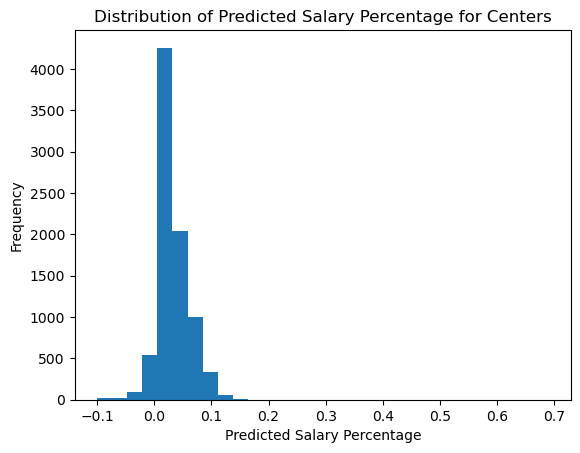

In [694]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(forwards[forwards['PRED_SALARY_PERCENTAGE'] > -0.1]['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Centers')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Forwards')

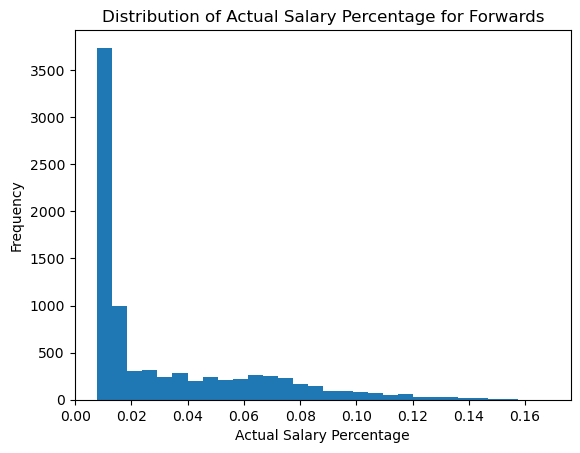

In [695]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(forwards['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Forwards')

In [696]:
# Filter players with over 41 GP
filtered_data = forwards[(forwards['GP'] > 60) & (forwards['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,GOALS/60,TOTAL ASSISTS/60,FIRST ASSISTS/60,SHOTS/60,IXG/60,ISCF/60,IHDCF/60,...,XGF/GP,XGA/GP,HDCF/GP,OFF. ZONE FACEOFFS/GP,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,Differential
12522,col,jonathan drouin,2023-24,0.62,1.51,0.78,5.15,0.68,7.02,3.74,...,1.1818,0.7576,4.7273,8.5000,"$825,000.00","$4,784,662.00","$3,959,662.00",0.009880,0.057301,3959662.0
12841,"mtl, wpg",sean monahan,2023-24,1.00,1.37,0.81,6.83,0.99,8.06,4.60,...,1.1143,1.0571,4.1429,7.6286,"$2,000,000.00","$5,852,511.00","$3,852,511.00",0.023772,0.070090,3852511.0
12937,dal,wyatt johnston,2023-24,1.31,1.36,1.11,9.09,1.25,11.21,5.50,...,0.9714,0.7571,3.9000,5.6143,"$1,000,417.00","$4,514,854.00","$3,514,437.00",0.010709,0.054070,3514437.0
12765,chi,philipp kurashev,2023-24,0.70,1.50,1.10,5.60,0.67,6.05,2.60,...,1.0794,1.0317,4.0159,9.3492,"$2,250,000.00","$5,672,839.00","$3,422,839.00",0.026946,0.067938,3422839.0
12922,nyr,vincent trocheck,2023-24,0.97,1.69,1.17,7.48,1.14,10.42,4.62,...,1.6000,1.1286,5.5571,9.3429,"$5,625,000.00","$8,928,810.00","$3,303,810.00",0.067365,0.106932,3303810.0
12398,s.j,fabian zetterlund,2023-24,0.83,0.65,0.60,7.53,0.90,8.59,3.46,...,1.0000,1.1014,3.5362,7.2174,"$1,450,000.00","$4,575,957.00","$3,125,957.00",0.017365,0.054802,3125957.0
12869,chi,taylor raddysh,2023-24,0.29,0.40,0.17,6.38,0.77,6.27,3.45,...,0.7385,0.8769,2.8769,5.0769,"$758,333.00","$3,836,117.00","$3,077,784.00",0.009082,0.045942,3077784.0
12845,car,seth jarvis,2023-24,1.19,1.38,0.83,7.11,1.18,9.27,5.51,...,1.1714,0.8571,4.4571,8.2571,"$1,394,167.00","$4,408,236.00","$3,014,069.00",0.010709,0.052793,3014069.0
12381,"cgy, van",elias lindholm,2023-24,0.56,1.17,0.56,6.91,0.83,6.60,3.28,...,1.1143,1.1714,3.9857,8.9857,"$4,850,000.00","$7,847,422.00","$2,997,422.00",0.058084,0.093981,2997422.0
12748,phi,owen tippett,2023-24,1.38,1.16,0.77,13.76,1.17,11.39,3.85,...,0.9697,0.7121,3.6364,7.8182,"$1,500,000.00","$4,283,378.00","$2,783,378.00",0.017964,0.051298,2783378.0


In [697]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(10)

,TEAM,PLAYER,SEASON,GOALS/60,TOTAL ASSISTS/60,FIRST ASSISTS/60,SHOTS/60,IXG/60,ISCF/60,IHDCF/60,...,XGF/GP,XGA/GP,HDCF/GP,OFF. ZONE FACEOFFS/GP,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,Differential
12195,nyi,anders lee,2023-24,0.94,0.72,0.11,8.56,1.59,12.04,8.34,...,0.9710,0.7391,4.1014,6.3913,"$7,000,000.00","$3,615,651.00","$-3,384,349.00",0.083832,0.043301,-3384349.0
12207,t.b,anthony cirelli,2023-24,0.71,0.99,0.57,5.16,0.70,6.15,3.50,...,1.0441,1.0441,3.8235,5.0882,"$6,250,000.00","$2,785,403.00","$-3,464,597.00",0.074850,0.033358,-3464597.0
12369,buf,dylan cozens,2023-24,0.77,1.33,1.07,8.88,1.01,8.93,3.62,...,0.9706,1.0441,3.1618,6.6176,"$7,100,000.00","$3,588,905.00","$-3,511,095.00",0.085030,0.042981,-3511095.0
12223,tor,auston matthews,2023-24,2.42,1.36,0.85,12.19,1.48,14.91,6.71,...,1.6269,1.0000,6.8507,9.6269,"$11,640,250.00","$7,924,231.00","$-3,716,019.00",0.139404,0.094901,-3716019.0
12565,stl,kevin hayes,2023-24,0.77,0.83,0.30,8.00,0.85,6.17,2.91,...,0.7000,0.6857,2.5000,4.2857,"$7,142,857.00","$3,311,538.00","$-3,831,319.00",0.085543,0.039659,-3831319.0
12524,cgy,jonathan huberdeau,2023-24,0.46,1.75,1.08,5.71,0.75,6.89,2.73,...,1.1493,0.8209,4.1194,9.1493,"$10,500,000.00","$6,314,212.00","$-4,185,788.00",0.125749,0.075619,-4185788.0
12468,dal,jamie benn,2023-24,0.74,1.88,0.97,7.48,0.94,7.59,4.28,...,1.0286,0.6857,3.8714,7.3286,"$9,500,000.00","$4,924,755.00","$-4,575,245.00",0.113772,0.058979,-4575245.0
12489,buf,jeff skinner,2023-24,1.39,1.22,0.70,10.80,1.21,11.79,4.12,...,1.0476,0.8571,3.4762,8.2698,"$9,000,000.00","$4,147,535.00","$-4,852,465.00",0.107784,0.049671,-4852465.0
12769,l.a,pierre-luc dubois,2023-24,0.83,0.99,0.61,7.00,1.04,8.32,4.02,...,0.9565,0.6812,3.4638,6.5217,"$8,500,000.00","$3,628,910.00","$-4,871,090.00",0.101796,0.043460,-4871090.0
12806,col,ryan johansen,2023-24,0.91,0.70,0.49,5.45,0.67,5.24,3.00,...,0.6825,0.6349,2.5873,4.9048,"$8,000,000.00","$2,985,114.00","$-5,014,886.00",0.095808,0.035750,-5014886.0


In [698]:
filtered_data[filtered_data['PLAYER'] == 'warren foegele'][display_features]

,PLAYER,SEASON,GOALS/60,TOTAL ASSISTS/60,FIRST ASSISTS/60,SHOTS/60,IXG/60,ISCF/60,IHDCF/60,RUSH ATTEMPTS/60,...,GA/GP,XGF/GP,XGA/GP,HDCF/GP,OFF. ZONE FACEOFFS/GP,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE
12930,warren foegele,2023-24,1.04,1.23,0.78,10.1,1.33,12.1,6.02,0.78,...,0.6418,0.791,0.6119,3.6119,4.2985,"$2,750,000.00","$2,126,748.00","$-623,252.00",0.032934,0.02547
